# Stroke Prognosis: Analisis final de Modelos

<p>
Curso de Minería de Datos <br>
Autor: Cristian Pavez Hormazábal
</p>

In [49]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Importación de datos
dataset = pd.read_csv("all-data.csv")

In [19]:
# Formatear el dataset
formated_dataset = dataset.drop('id', axis=1)
formated_dataset['gender'] = formated_dataset['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
formated_dataset['ever_married'] = formated_dataset['ever_married'].map({'Yes': 1, 'No': 0})
formated_dataset['work_type'] = formated_dataset['work_type'].map({'Private': 4, 'Self-employed': 2, 'Govt_job': 3, 'children': 1, 'Never_worked': 0})
formated_dataset['Residence_type'] = formated_dataset['Residence_type'].map({'Rural': 0, 'Urban': 1})
formated_dataset['smoking_status'] = formated_dataset['smoking_status'].map({'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3})
formated_dataset['stroke'] = formated_dataset['stroke'].map({1: 0, 0: 1})

# Dividir el dataset en personas con y sin stroke
no_stroke_data = formated_dataset[formated_dataset['stroke'] == 1]
stroke_data = formated_dataset[formated_dataset['stroke'] == 0]

# Sobre-representar los datos de stroke
stroke_data_overrepresented = pd.concat([stroke_data] * 5, ignore_index=True)

# Combinar los datasets
balanced_dataset = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Para el dataset sin filas nulas
dataset1 = balanced_dataset.dropna()
x1 = dataset1.drop('stroke', axis=1)
y1 = dataset1['stroke']

# Para el dataset sin IMC
dataset2 = balanced_dataset.drop('bmi', axis=1)
dataset2 = dataset2.dropna()
x2 = dataset2.drop('stroke', axis=1)
y2 = dataset2['stroke']

In [61]:
# Definir Decision Tree
def evaluar_y_graficar_decision_tree(x, y):
    parametros_a_evaluar = {
        'max_depth': [3*i+1 for i in range(20)],
        'min_samples_split': [3*i+2 for i in range(30)],
        'min_samples_leaf': [3*i+1 for i in range(20)],
        'max_leaf_nodes': [50*i+2 for i in range(10)]
    }

    for parametro, valores in parametros_a_evaluar.items():
        print(f"Evaluando parámetro: {parametro}")
        data = []

        for val in valores:
            for _ in range(20):
                X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

                clf = DecisionTreeClassifier(**{parametro: val})
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred, zero_division=0)
                rec = recall_score(y_test, y_pred, zero_division=0)

                data.append({
                    "param_value": val,
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec
                })

        df = pd.DataFrame(data)

        # Calcular promedios
        resumen = df.groupby("param_value")[["accuracy", "precision", "recall"]].mean().reset_index()
        resumen = resumen.melt(id_vars="param_value", var_name="Métrica", value_name="Promedio")

        plt.figure(figsize=(10, 6))
        sns.lineplot(data=resumen, x="param_value", y="Promedio", hue="Métrica", marker="o", palette="Set2")
        plt.ylim(0, 1)
        plt.title(f"Promedios de Accuracy, Precision y Recall para '{parametro}'")
        plt.xlabel(f"Valor de {parametro}")
        plt.ylabel("Score promedio")
        plt.legend(title="Métrica")
        plt.tight_layout()
        plt.show()



Evaluando parámetro: max_depth


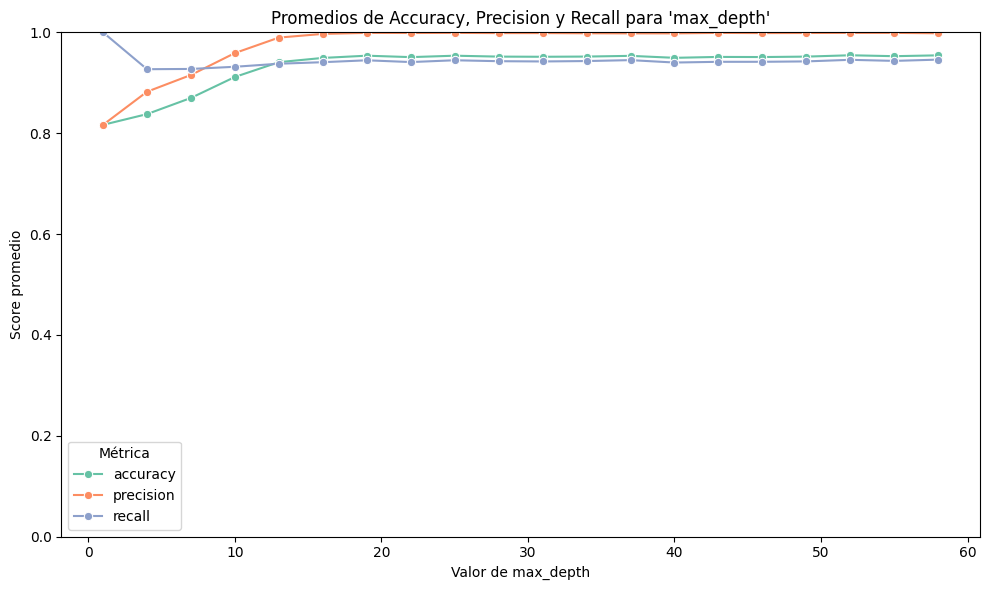

Evaluando parámetro: min_samples_split


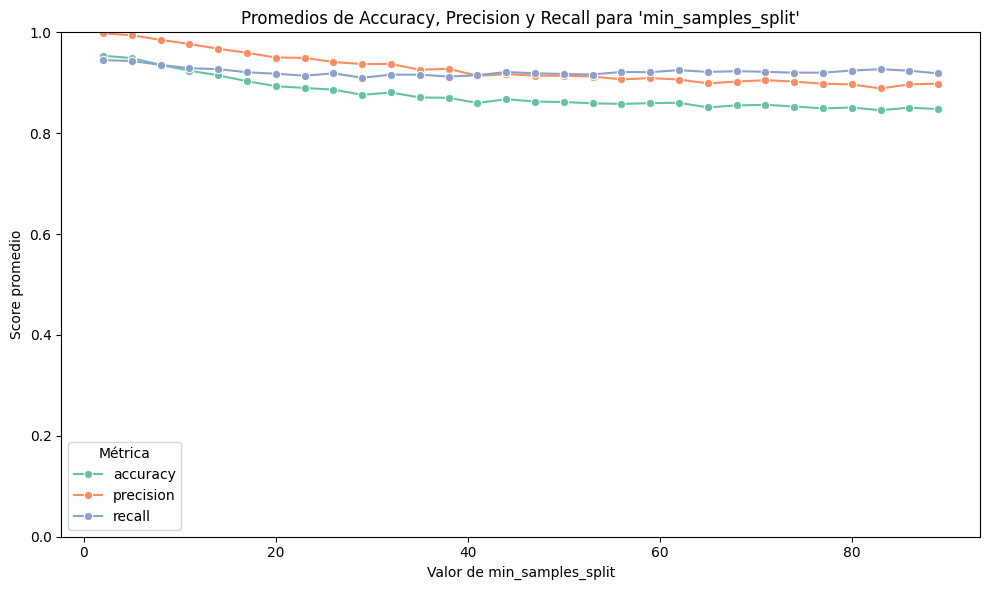

Evaluando parámetro: min_samples_leaf


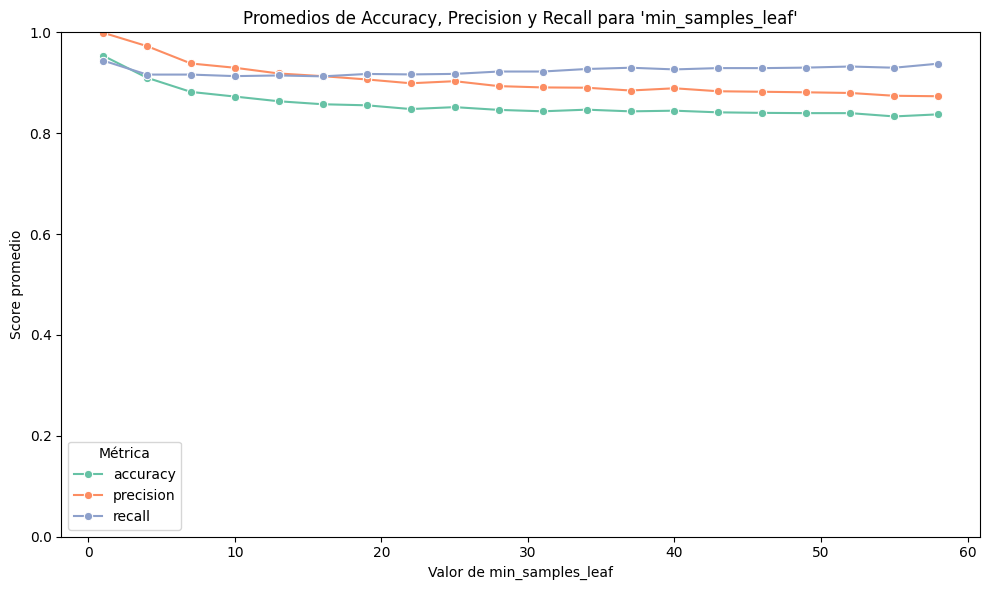

Evaluando parámetro: max_leaf_nodes


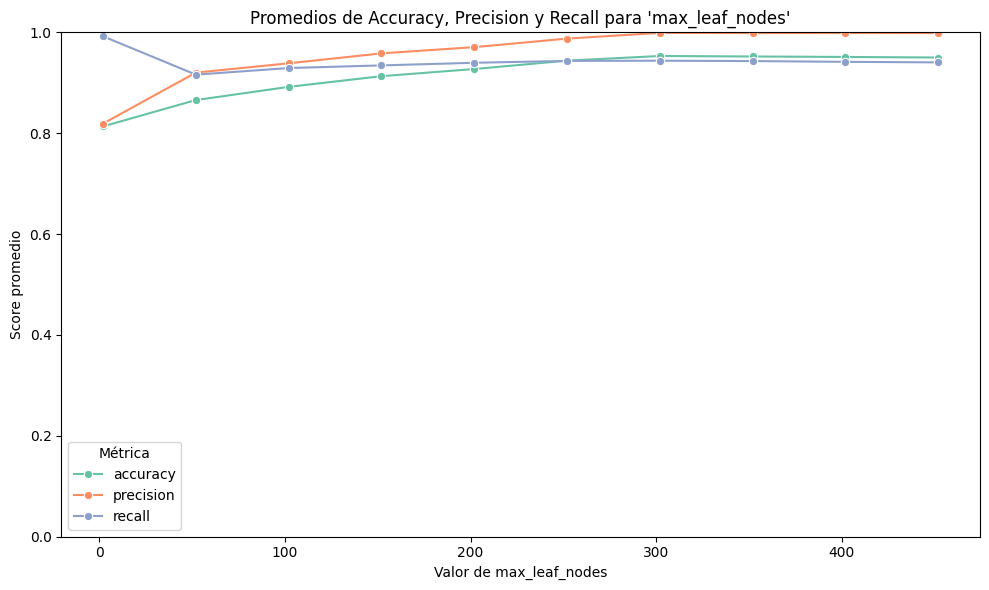

In [62]:
# DT para Dataset1

evaluar_y_graficar_decision_tree(x1,y1)

Evaluando parámetro: max_depth


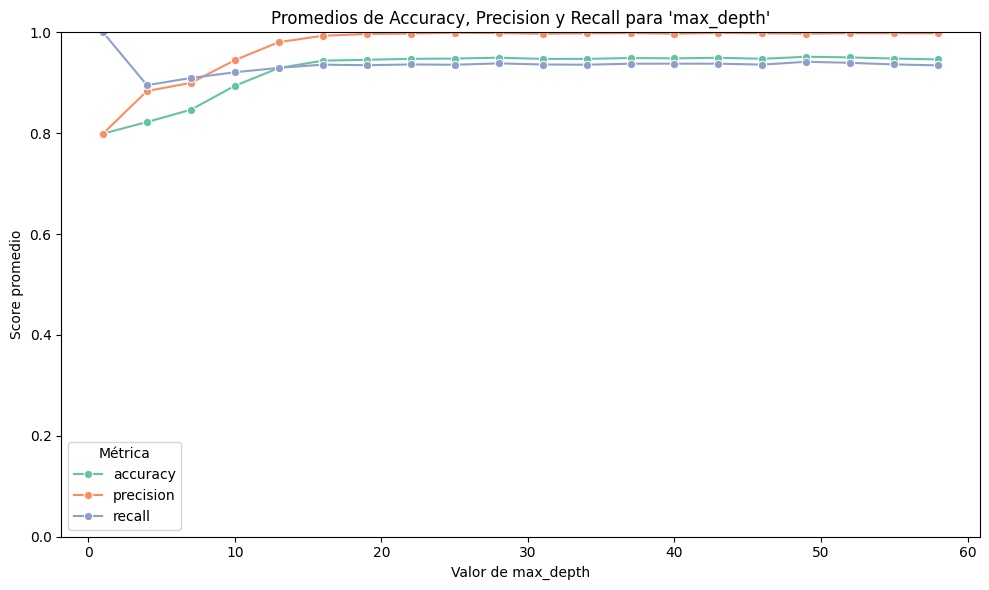

Evaluando parámetro: min_samples_split


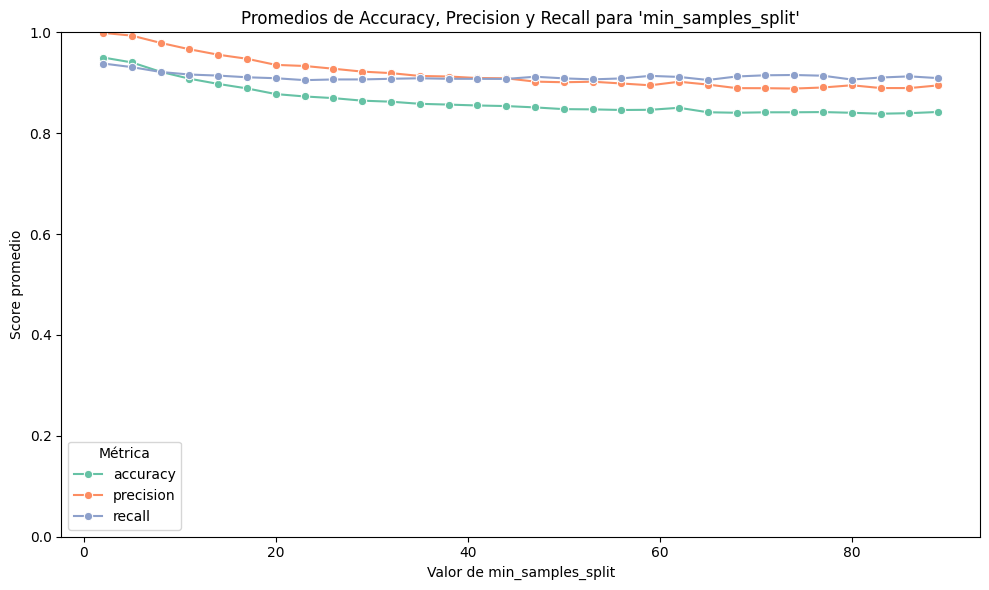

Evaluando parámetro: min_samples_leaf


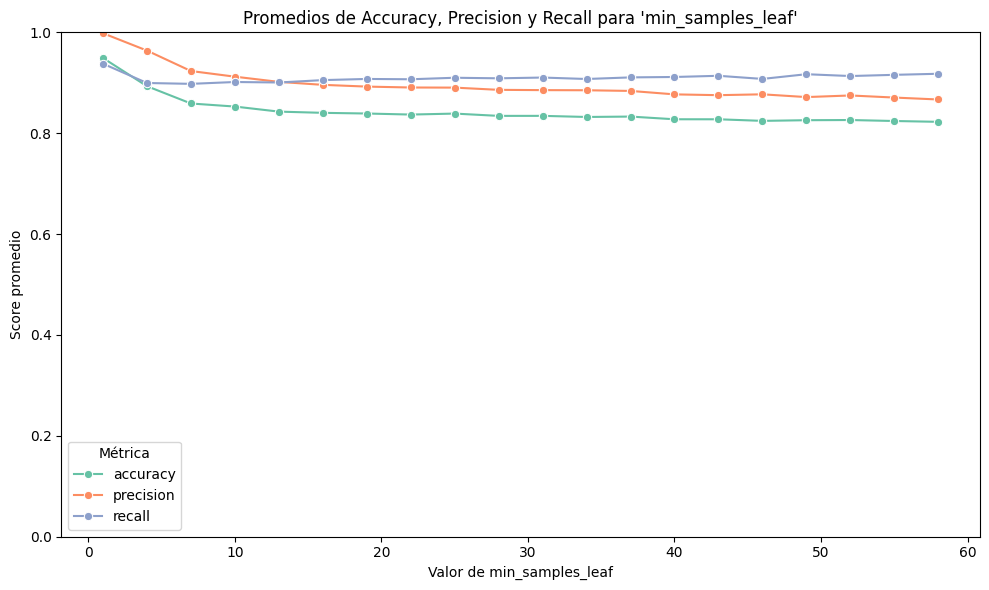

Evaluando parámetro: max_leaf_nodes


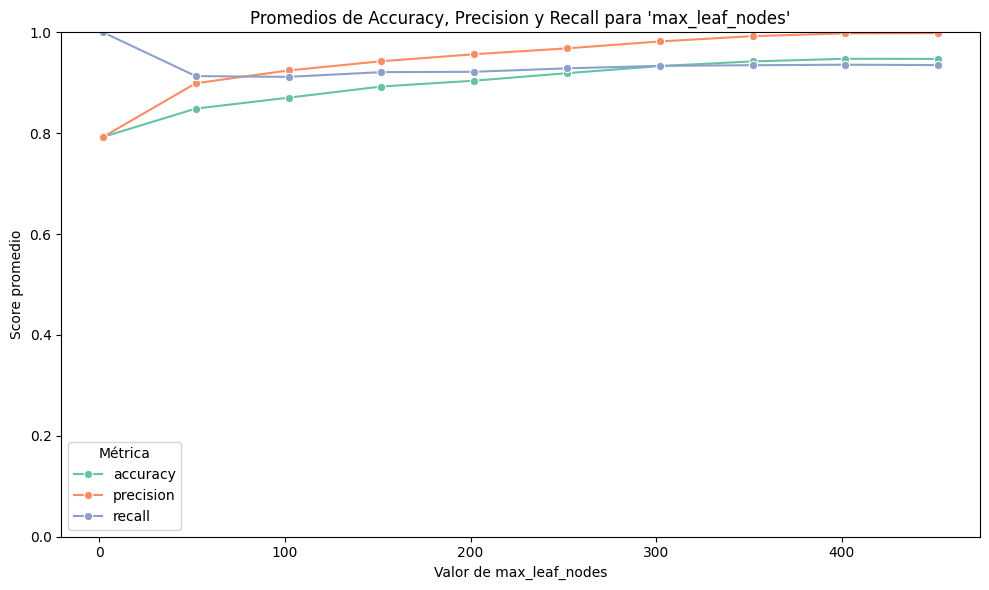

In [65]:
# DT para Dataset2
evaluar_y_graficar_decision_tree(x2,y2)

In [71]:
# Aplicar los modelos
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=15 , min_samples_split=2 , min_samples_leaf=2, max_leaf_nodes=30),
    "Random Forest": RandomForestClassifier(max_depth=15 , min_samples_split=2 , min_samples_leaf=2, max_leaf_nodes=30, n_estimators=100),
    }

def entrenar(x, y):
    all_results = []
    for name, model in models.items():
        results = []
        for i in range(10):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=i)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            # Obtener probabilidades o scores para ROC
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(x_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(x_test)
            else:
                y_score = None
            cm = sk.metrics.confusion_matrix(y_test, y_pred)
            acc = sk.metrics.accuracy_score(y_test, y_pred)
            prec = sk.metrics.precision_score(y_test, y_pred)
            rec = sk.metrics.recall_score(y_test, y_pred)
            f1 = sk.metrics.f1_score(y_test, y_pred)
            results.append({
                "confusion_matrix": cm,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "y_test": y_test,
                "y_score": y_score
            })
        all_results.append({f"{name}": results})
        if name == "Decision Tree":
            plt.figure(figsize=(20, 10))
            sk.tree.plot_tree(model, feature_names=x.columns, class_names=['No Stroke', 'Stroke'], filled=True, rounded=True, fontsize=10)
            plt.title("Estructura del Árbol de Decisión")
            plt.show()
    return all_results
    
def graficar_resultados(all_results):
    for model in all_results:
        name, results = list(model.items())[0]
        cms = [r['confusion_matrix'] for r in results]
        tps = [cm[0][0] for cm in cms]
        fns = [cm[0][1] for cm in cms]
        fps = [cm[1][0] for cm in cms]
        tns = [cm[1][1] for cm in cms]
        accs = [r['accuracy'] for r in results]
        precs = [r['precision'] for r in results]
        recs = [r['recall'] for r in results]
        f1s = [r['f1_score'] for r in results]

        # Imprimir métricas
        print("Accuracy:", np.mean(accs))
        print("precision:", np.mean(precs))
        print("recall:", np.mean(recs))
        
        # Crear boxplot de las métricas
        data = [accs, precs, recs, f1s]
        labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        plt.figure(figsize=(8, 6))
        plt.boxplot(data, tick_labels=labels)
        plt.title(f'Boxplot de métricas para {name}')
        plt.ylabel('Score')
        plt.ylim(0, 1) 
        plt.grid(True)
        plt.show()

        # Matriz de confusión promedio
        avg_cm = np.array([
            [np.mean(tps), np.mean(fns)],
            [np.mean(fps), np.mean(tns)]
        ])
        plt.figure(figsize=(4, 4))
        sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Pred. Stroke", "Pred. no Stroke"], yticklabels=["Real Stroke", "Real no Stroke"])
        plt.title(f'Matriz de confusión promedio para {name}')
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # Curva ROC
        from sklearn.metrics import roc_curve, auc
        # Curva ROC promedio
        fpr_list = []
        tpr_list = []
        auc_list = []
        for r in results:
            # Verifica si el modelo tiene predict_proba o decision_function
            try:
                y_score = r.get('y_score', None)
                if y_score is not None:
                    fpr, tpr, _ = roc_curve(r['y_test'], y_score)
                    fpr_list.append(fpr)
                    tpr_list.append(tpr)
                    auc_list.append(auc(fpr, tpr))
            except Exception as e:
                continue

        if fpr_list and tpr_list:
            plt.figure(figsize=(6, 6))
            for i, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list)):
                plt.plot(fpr, tpr, alpha=0.3, label=f'ROC split {i+1}')
            mean_auc = np.mean(auc_list)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Curvas ROC solapadas para {name}\n(AUC promedio = {mean_auc:.2f})')
            plt.legend(loc='lower right', fontsize='small', ncol=2)
            plt.grid(True)
            plt.show()        

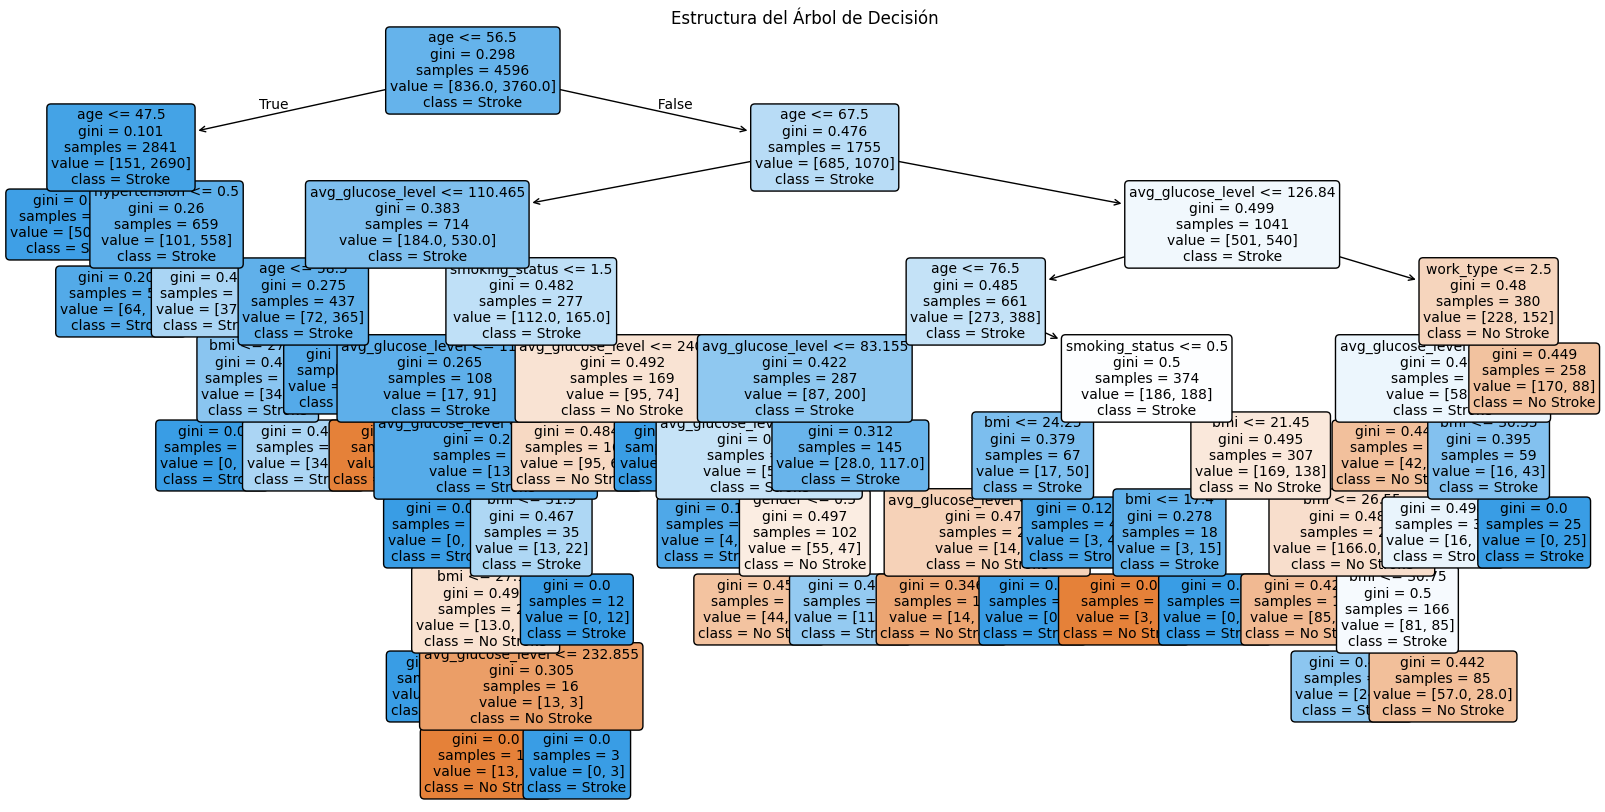

Accuracy: 0.8512619669277633
precision: 0.8992630431401677
recall: 0.9215467657712617


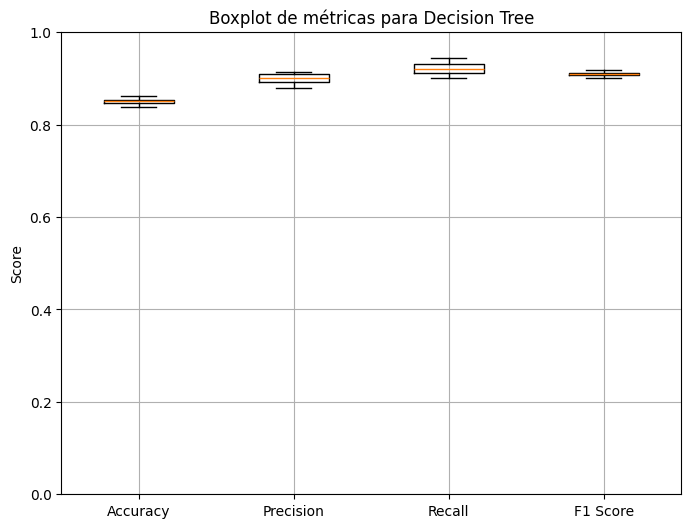

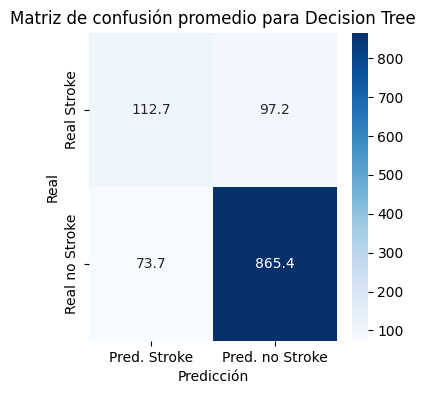

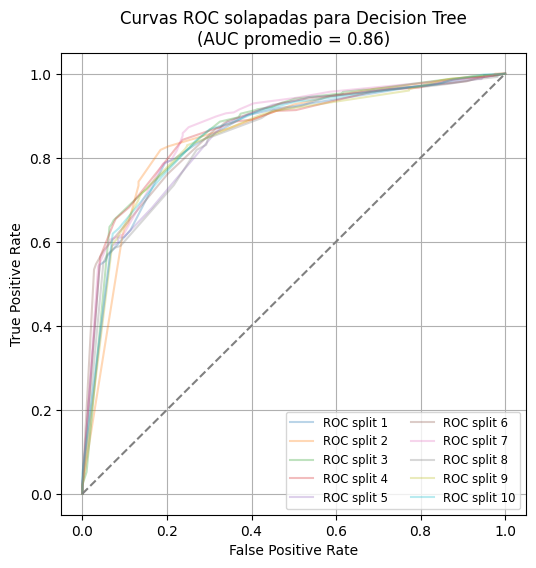

Accuracy: 0.8661444734551784
precision: 0.8744584995508873
recall: 0.9764911062024817


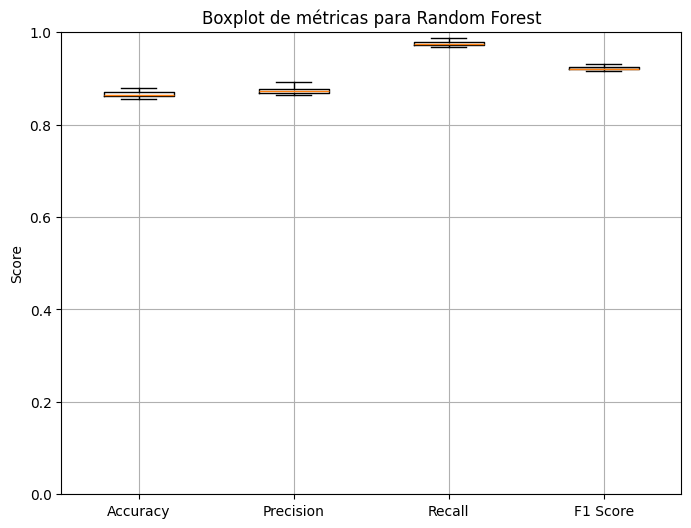

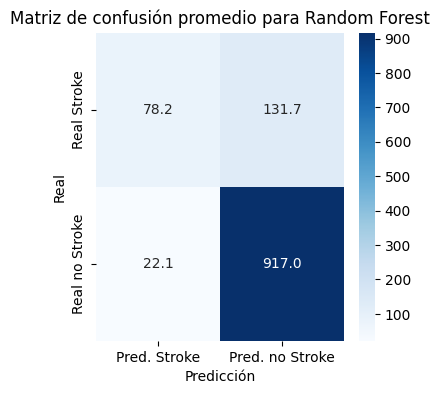

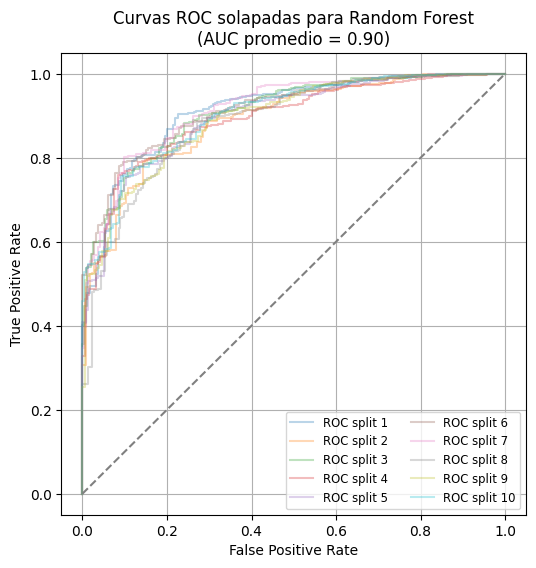

In [72]:
# Set sin null balanceado
results = entrenar(x1, y1)

graficar_resultados(results)

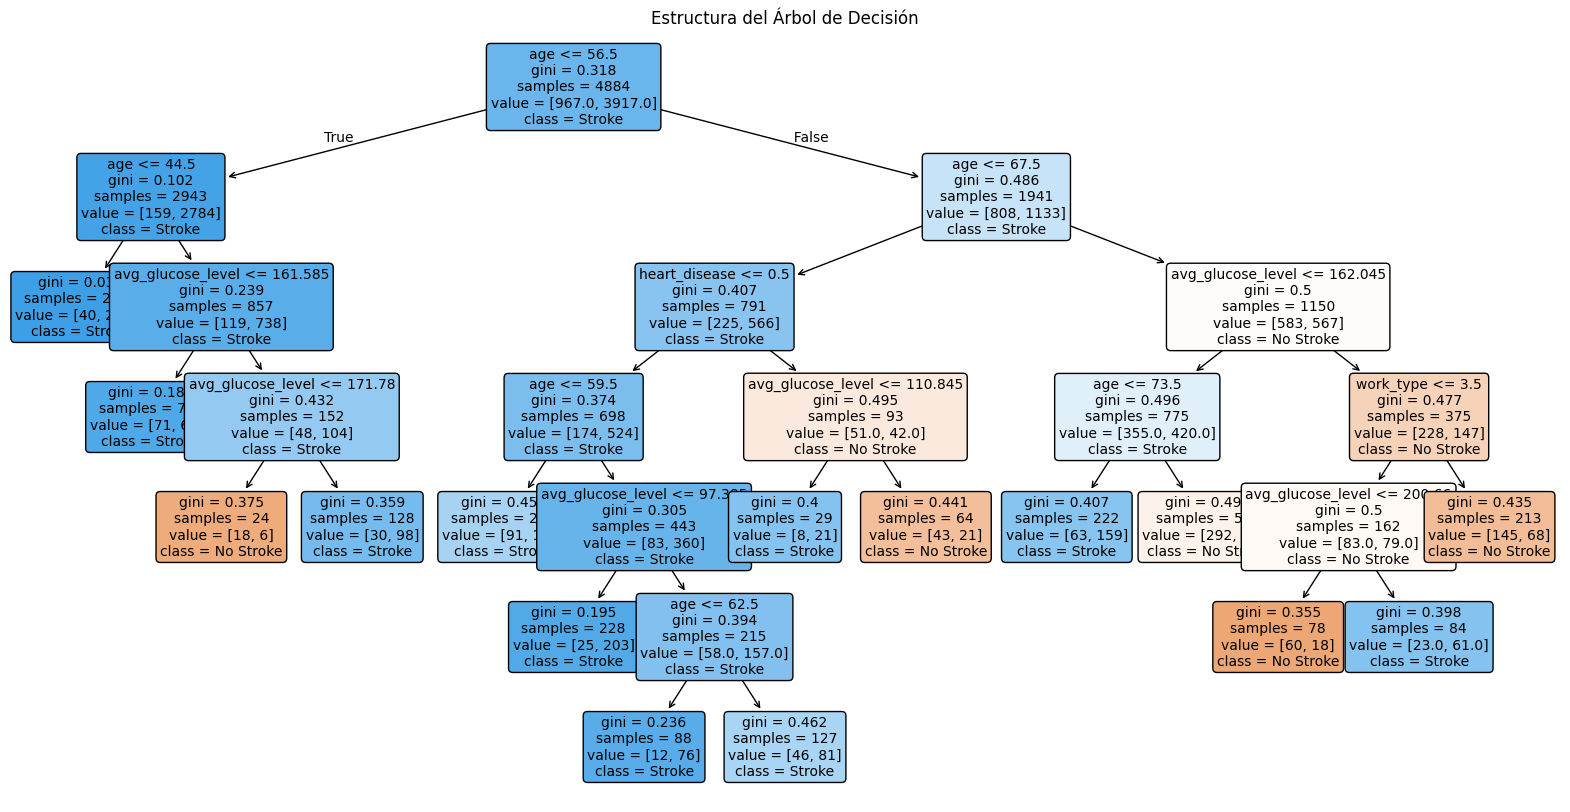

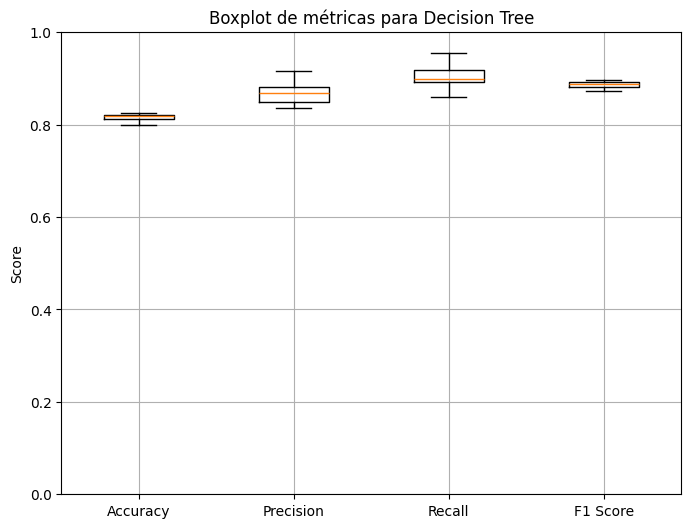

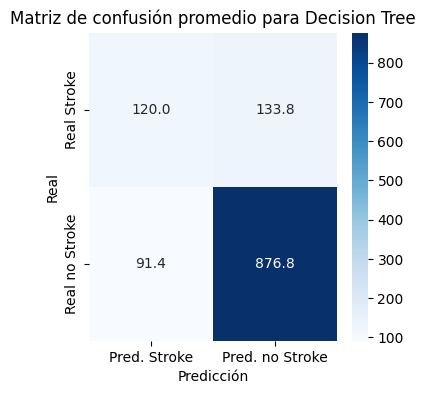

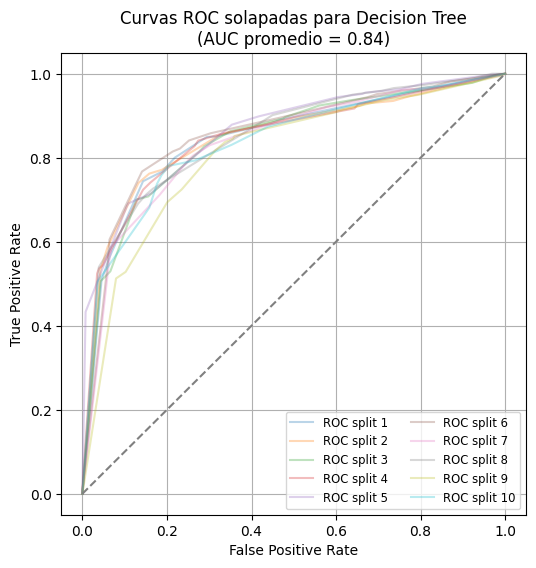

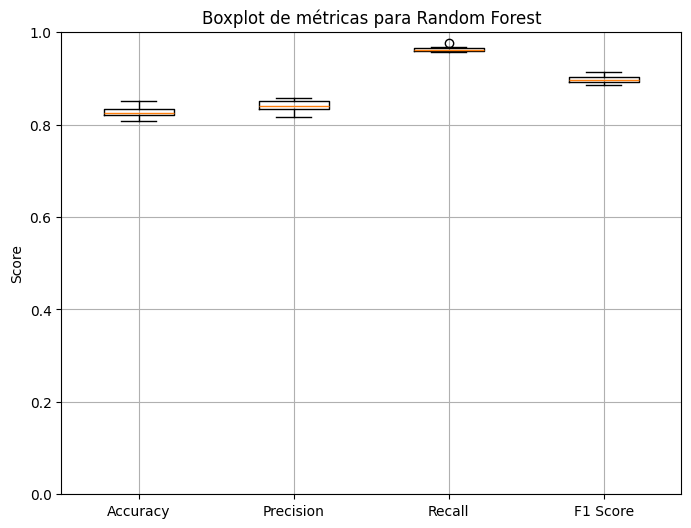

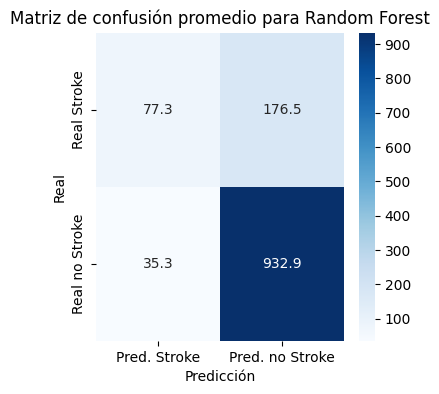

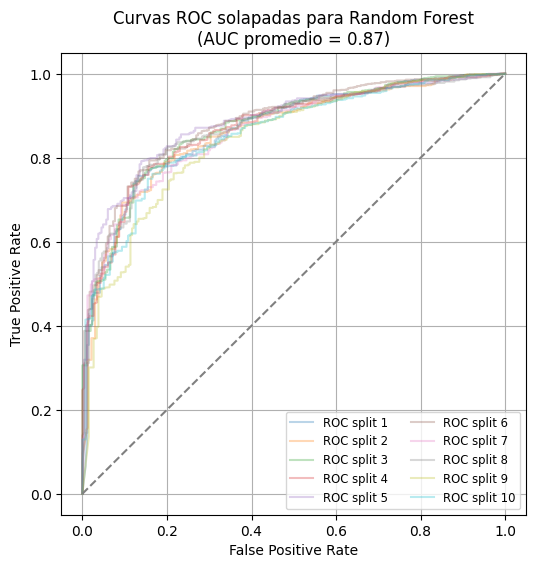

In [52]:
# Set sin IMC balanceado
results = entrenar(x2, y2)

graficar_resultados(results)

In [79]:
# Modelos sin restricciones
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    }

# Pasa ahora a 100 veces
def entrenar(x, y):
    all_results = []
    for name, model in models.items():
        results = []
        for i in range(100):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=i)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            # Obtener probabilidades o scores para ROC
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(x_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(x_test)
            else:
                y_score = None
            cm = sk.metrics.confusion_matrix(y_test, y_pred)
            acc = sk.metrics.accuracy_score(y_test, y_pred)
            prec = sk.metrics.precision_score(y_test, y_pred)
            rec = sk.metrics.recall_score(y_test, y_pred)
            f1 = sk.metrics.f1_score(y_test, y_pred)
            results.append({
                "confusion_matrix": cm,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "y_test": y_test,
                "y_score": y_score
            })
        all_results.append({f"{name}": results})
        if name == "Decision Tree":
            plt.figure(figsize=(20, 10))
            sk.tree.plot_tree(model, feature_names=x.columns, class_names=['No Stroke', 'Stroke'], filled=True, rounded=True, fontsize=10)
            plt.title("Estructura del Árbol de Decisión")
            plt.show()
    return all_results

def graficar_resultados(all_results):
    for model in all_results:
        name, results = list(model.items())[0]
        cms = [r['confusion_matrix'] for r in results]
        tps = [cm[0][0] for cm in cms]
        fns = [cm[0][1] for cm in cms]
        fps = [cm[1][0] for cm in cms]
        tns = [cm[1][1] for cm in cms]
        accs = [r['accuracy'] for r in results]
        precs = [r['precision'] for r in results]
        recs = [r['recall'] for r in results]
        f1s = [r['f1_score'] for r in results]

        # Imprimir métricas
        print("Accuracy:", np.mean(accs))
        print("precision:", np.mean(precs))
        print("recall:", np.mean(recs))
        
        # Crear boxplot de las métricas
        data = [accs, precs, recs, f1s]
        labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        plt.figure(figsize=(8, 6))
        plt.boxplot(data, tick_labels=labels)
        plt.title(f'Boxplot de métricas para {name}')
        plt.ylabel('Score')
        plt.ylim(0, 1) 
        plt.grid(True)
        plt.show()

        # Matriz de confusión promedio
        avg_cm = np.array([
            [np.mean(tps), np.mean(fns)],
            [np.mean(fps), np.mean(tns)]
        ])
        plt.figure(figsize=(4, 4))
        sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Pred. Stroke", "Pred. no Stroke"], yticklabels=["Real Stroke", "Real no Stroke"])
        plt.title(f'Matriz de confusión promedio para {name}')
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # Curva ROC
        from sklearn.metrics import roc_curve, auc
        # Curva ROC promedio
        fpr_list = []
        tpr_list = []
        auc_list = []
        for r in results:
            # Verifica si el modelo tiene predict_proba o decision_function
            try:
                y_score = r.get('y_score', None)
                if y_score is not None:
                    fpr, tpr, _ = roc_curve(r['y_test'], y_score)
                    fpr_list.append(fpr)
                    tpr_list.append(tpr)
                    auc_list.append(auc(fpr, tpr))
            except Exception as e:
                continue

        if fpr_list and tpr_list:
            plt.figure(figsize=(6, 6))
            for i, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list)):
                plt.plot(fpr, tpr, alpha=0.3)
            mean_auc = np.mean(auc_list)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Curvas ROC solapadas para {name}\n(AUC promedio = {mean_auc:.2f})')
            plt.legend(loc='lower right', fontsize='small', ncol=2)
            plt.grid(True)
            plt.show()      

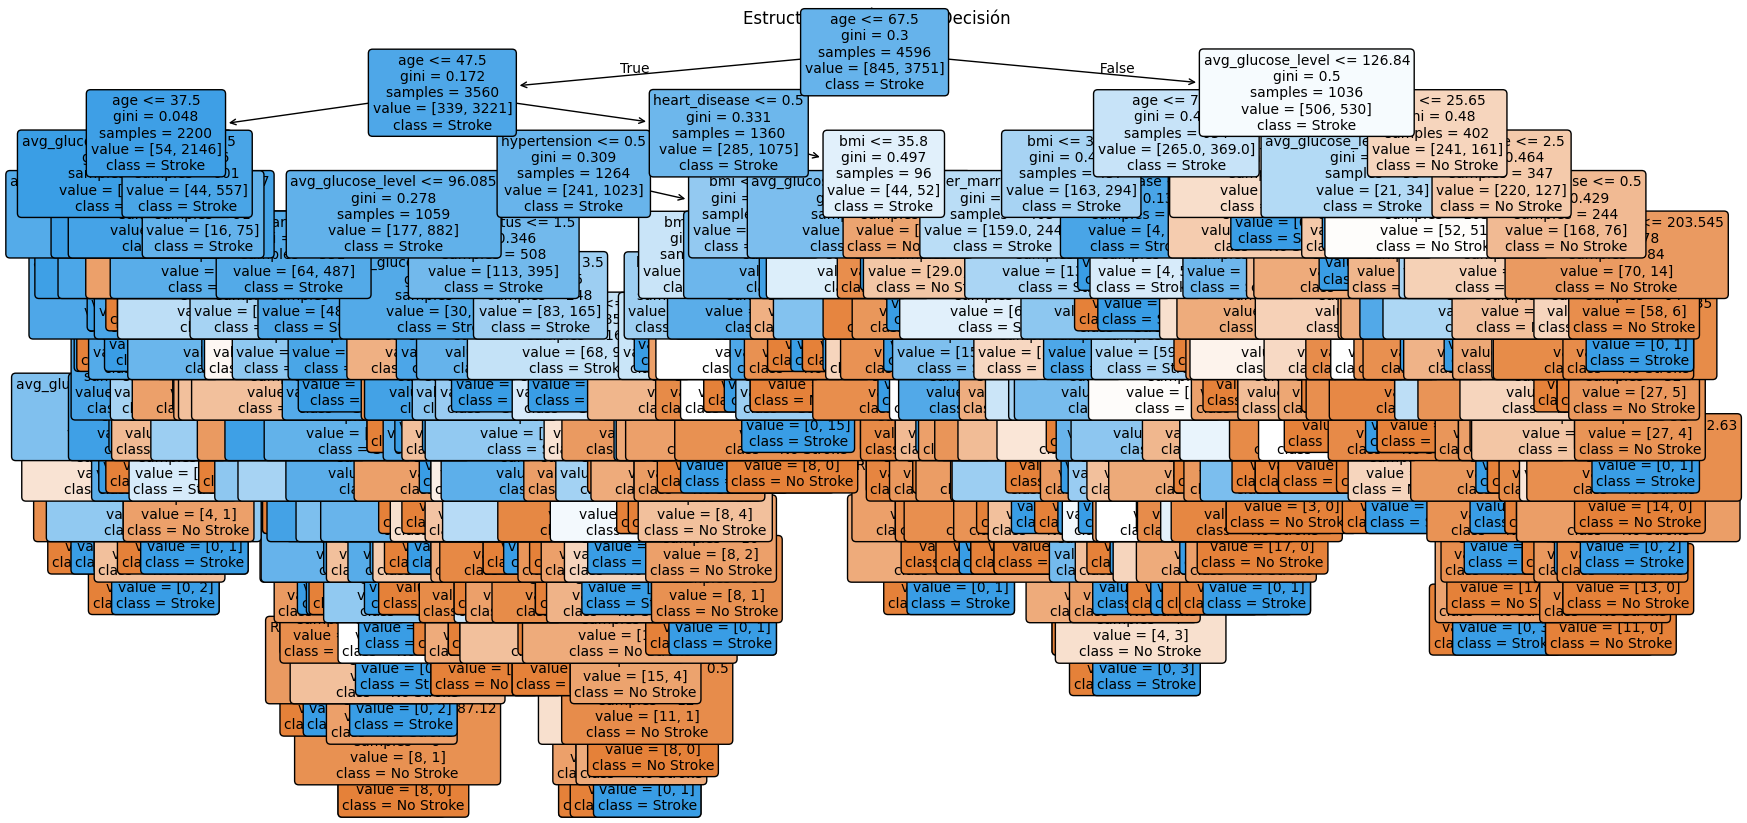

Accuracy: 0.9584943429068754
precision: 0.9994416542305627
recall: 0.9497015369883899


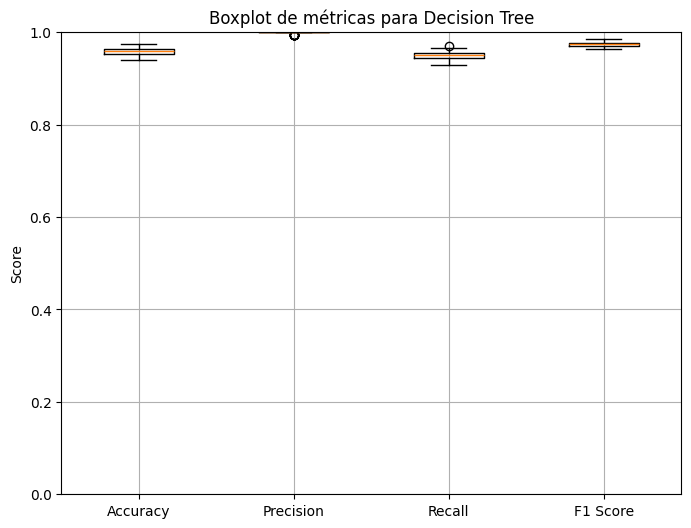

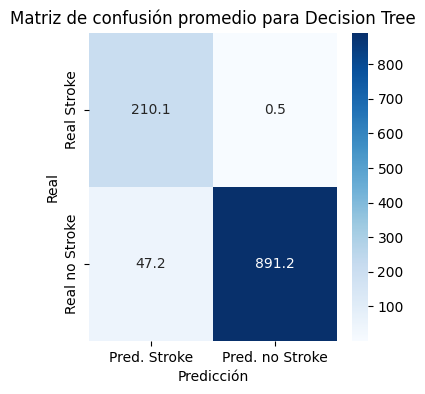

C:\Users\cjpav\AppData\Local\Temp\ipykernel_28652\3355660266.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', fontsize='small', ncol=2)


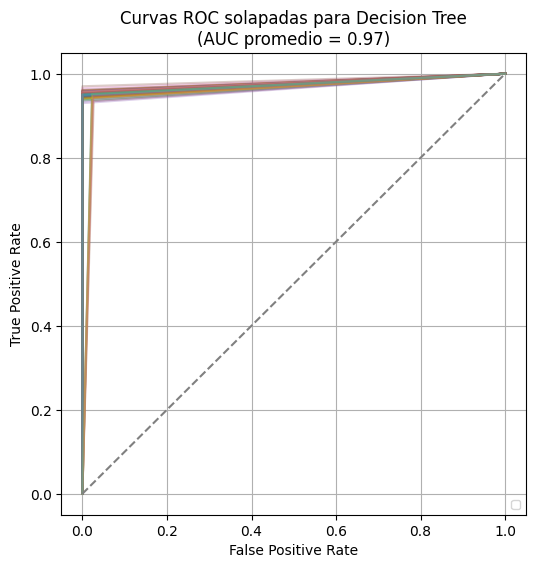

Accuracy: 0.9889295039164492
precision: 0.9994637167598232
recall: 0.9869773896420394


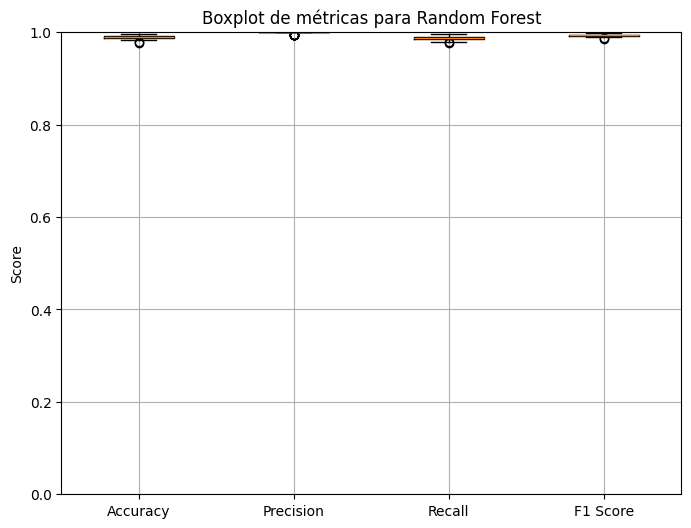

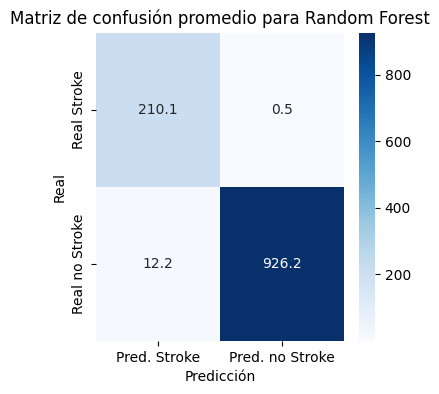

C:\Users\cjpav\AppData\Local\Temp\ipykernel_28652\3355660266.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', fontsize='small', ncol=2)


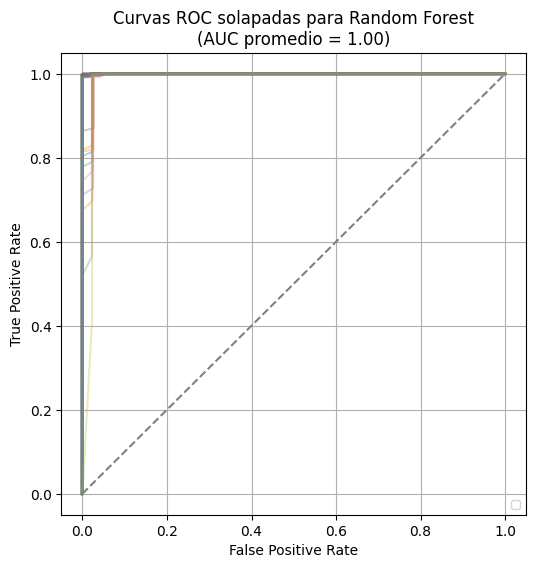

In [80]:
# Set sin null balanceado para modelo sin restriccion
results = entrenar(x1, y1)

graficar_resultados(results)

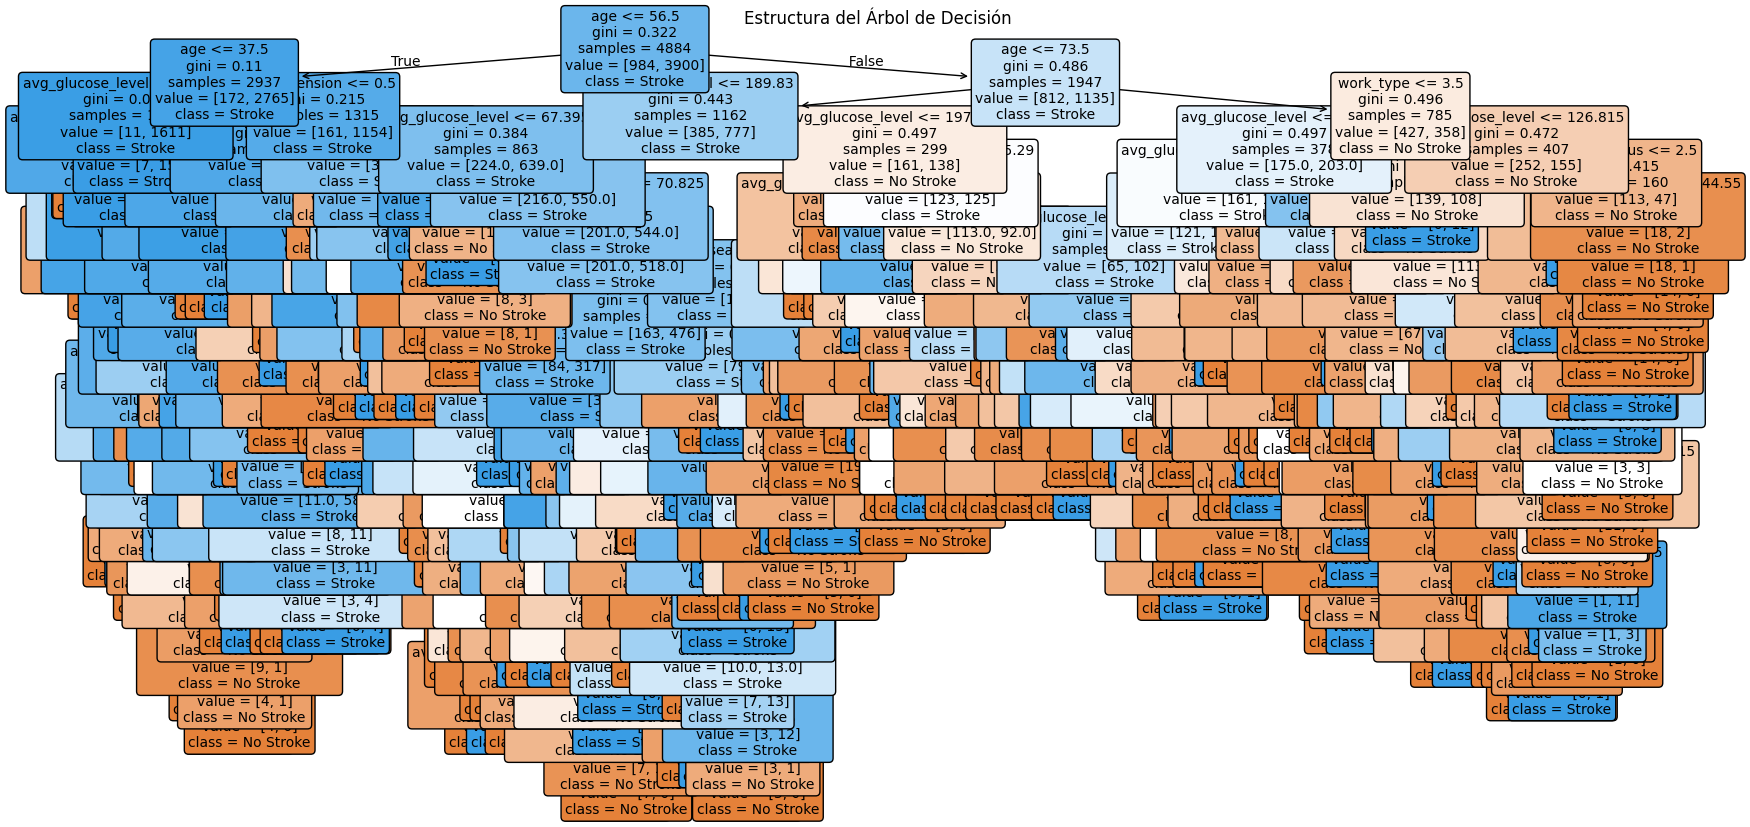

Accuracy: 0.9559819967266776
precision: 0.9996211813969276
recall: 0.9450884532475748


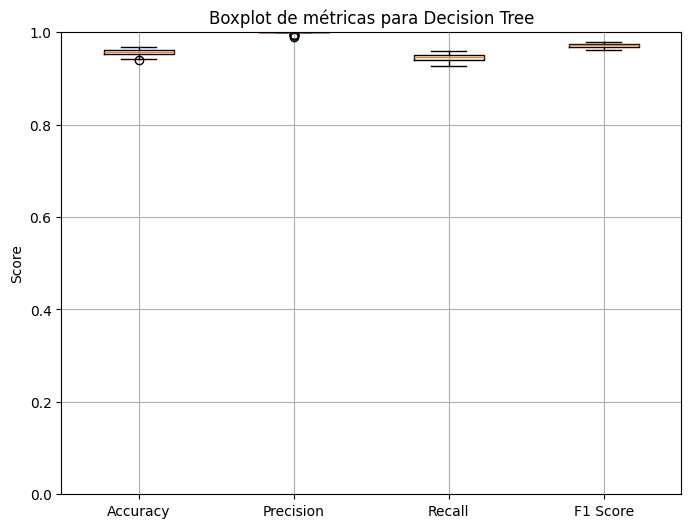

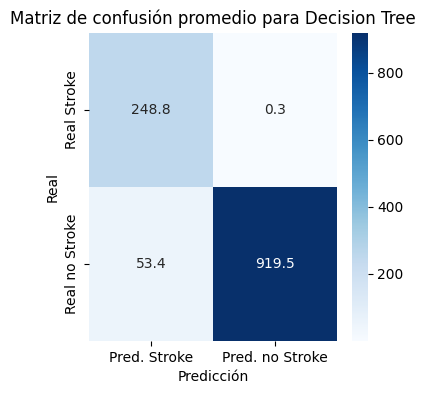

C:\Users\cjpav\AppData\Local\Temp\ipykernel_28652\3355660266.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', fontsize='small', ncol=2)


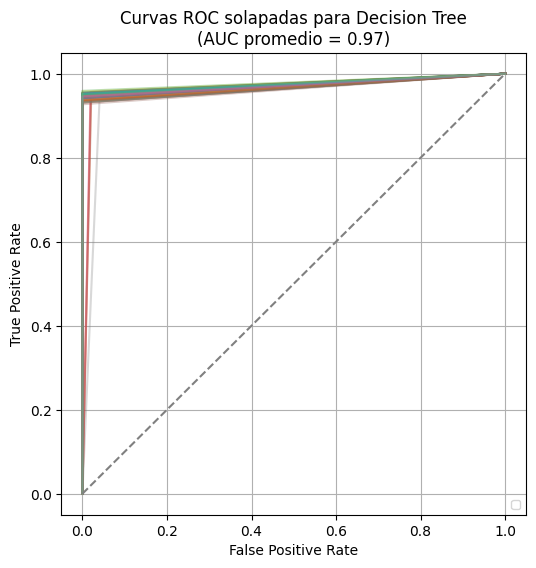

Accuracy: 0.9813911620294599
precision: 0.9995910548869196
recall: 0.9770322899396416


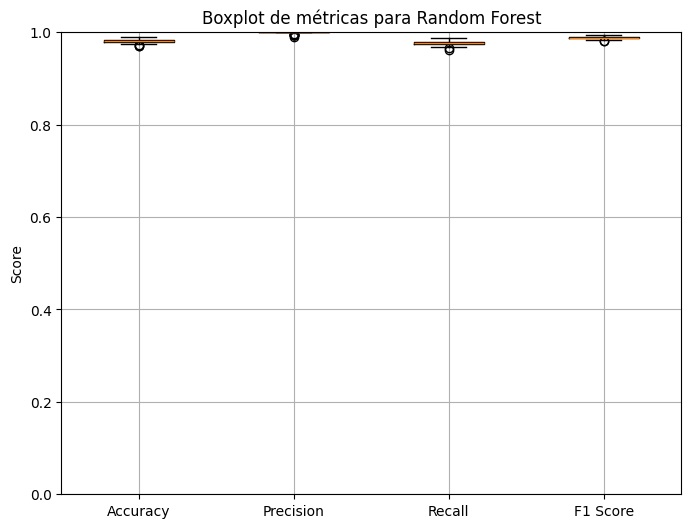

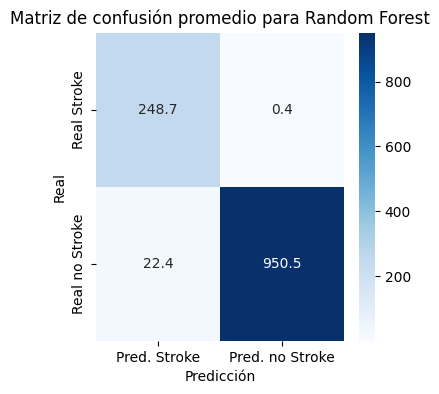

C:\Users\cjpav\AppData\Local\Temp\ipykernel_28652\3355660266.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', fontsize='small', ncol=2)


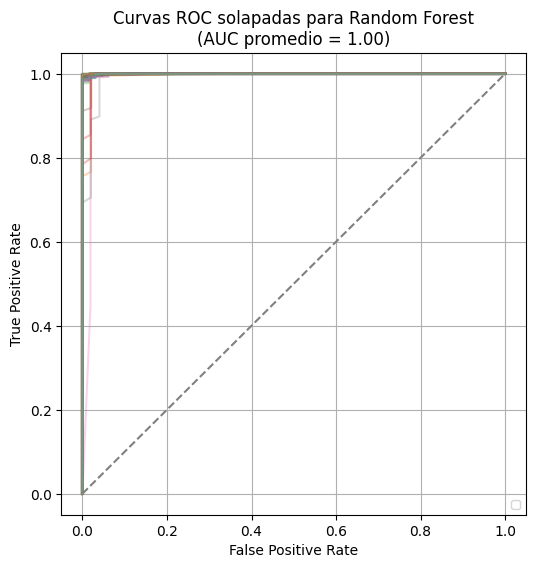

In [81]:
# Set sin IMC balanceado
results = entrenar(x2, y2)

graficar_resultados(results)